### SOCIAL MEDIA SENTIMENT ANALYSIS

### 1. Import Libraries

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\SUMEET
[nltk_data]     SAJJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd
import numpy as mp
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import string
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\SUMEET
[nltk_data]     SAJJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\SUMEET
[nltk_data]     SAJJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\SUMEET
[nltk_data]     SAJJAN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### 2. Load the  dataset

In [4]:
df_actual=pd.read_csv('Tweets.csv')
df_actual.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
def row_column_details(df):
    print("Number of rows=",df.shape[0])
    print("Number of columns=",df.shape[1])

In [6]:
row_column_details(df_actual)

Number of rows= 14640
Number of columns= 15


### 3. Data Preprocessing.

### a. Removing unnecessary columns and creating a new dataset.

In [7]:
df_new=df_actual[['airline_sentiment','text']].copy()

In [8]:
df_new.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [9]:
df_new.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [10]:
df_new.isnull().sum()  #Ther is no missing value

airline_sentiment    0
text                 0
dtype: int64

### b. Visualization

In [11]:
def display(df):
    
    plt.figure(figsize=(8, 6))
    ax = sns.histplot(df['airline_sentiment'], bins=5, color='yellow', discrete=True)
    plt.ylabel('Count')
    plt.title('Distribution of Airline Sentiments')

    # Add counts on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.xticks()
    plt.show()

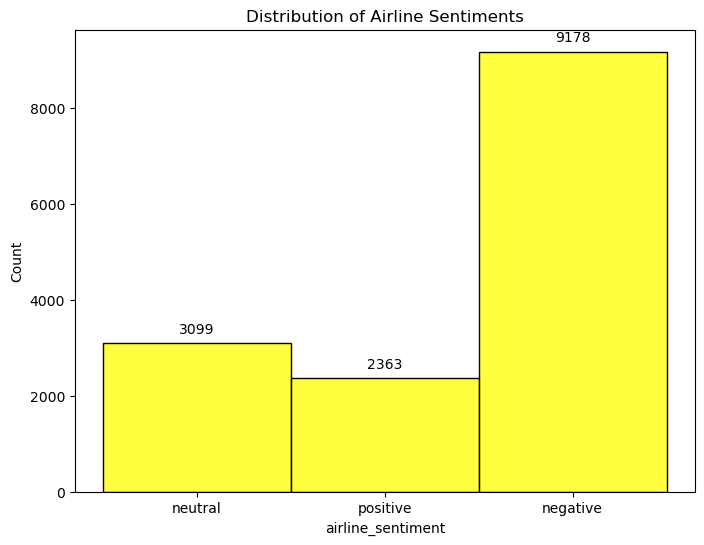

In [12]:
display(df_new)

### c. Casing, stopwords removing, Stemming and Lemmitizing

In [13]:
def preprocess_text(text):
    
    # Converting into any case.
    text = text.lower()

    # Removing #, @ etc.
    text = re.sub(r'@\w+|#', '', text)
    
    
    #Remove Punctuation.
    remove_punct=str.maketrans('', '', string.punctuation)
    text=text.translate(remove_punct)

    # Remove stopwords
    text_tokens = word_tokenize(text)
    filtered_tokens = [word for word in text_tokens if word not in stop_words]
    

    # Stemming
    sm = PorterStemmer()
    stemmed_words = [sm.stem(v) for v in filtered_tokens]

    # Lemmatizing
    lm = WordNetLemmatizer()
    lemma_words = [lm.lemmatize(w, pos='a') for w in stemmed_words]

    return ' '.join(lemma_words)
    

In [14]:
preprocess_text('Hi I m using this model.')

'hi use model'

In [15]:
df_new['res']=df_new.text.apply(preprocess_text)

In [16]:
df_new.head()

,airline_sentiment,text,res
0,neutral,@VirginAmerica What @dhepburn said.,said
1,positive,@VirginAmerica plus you've added commercials t...,plu youv ad commerci experi tacki
2,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take anoth trip
3,negative,@VirginAmerica it's really aggressive to blast...,realli aggress blast obnoxi entertain guest fa...
4,negative,@VirginAmerica and it's a really big bad thing...,realli big bad thing


### d. Vectorize Token and splitting data

In [17]:
tfid = TfidfVectorizer()
X = tfid.fit_transform(df_new['res'])
y =df_new['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Model training

### a. Random Forest Classifier

In [18]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [19]:
train_accuracy = rfc.score(X_train, y_train)
test_accuracy = rfc.score(X_test, y_test)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.9954747267759563
Test accuracy:  0.7790300546448088


### b. GradintBoostingClassifier

In [20]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

In [21]:
train_accuracy = gbc.score(X_train, y_train)
test_accuracy = gbc.score(X_test, y_test)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.7400956284153005
Test accuracy:  0.7332650273224044


### c. Support Vector Machine

In [22]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [23]:
train_accuracy = svm.score(X_train, y_train)
test_accuracy = svm.score(X_test, y_test)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.9559426229508197
Test accuracy:  0.7834699453551912


### d. Decision Tree Classifier

In [24]:
des = DecisionTreeClassifier()
des.fit(X_train,y_train)

DecisionTreeClassifier()

In [25]:
train_accuracy = des.score(X_train, y_train)
test_accuracy = des.score(X_test, y_test)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.9954747267759563
Test accuracy:  0.7151639344262295


### e. Naive Bayes

In [26]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [27]:
train_accuracy = nb.score(X_train, y_train)
test_accuracy = nb.score(X_test, y_test)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.720030737704918
Test accuracy:  0.6933060109289617


Test Accuracy is highest for Support Vector Machine.

### 5. Prediction

In [49]:
def prediction(model,comment,tfid):
    preprocessed_comment = preprocess_text(comment)
    preprocess_comment = tfid.transform([preprocessed_comment])
    predicted_label = model.predict(preprocess_comment)
    print(f"({comment}) is a","".join(map(str, predicted_label))," comment")

In [57]:
comment1 = "The food is not good."
comment2="Thanks for your assist"

prediction(svm,comment1,tfid)
prediction(svm,comment2,tfid)



(The food is not good.) is a negative  comment
(Thanks for your assist) is a positive  comment


### Thank You